In [1]:
import os 
import sys 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dense, Input, GlobalMaxPooling1D
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [2]:
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
# Download the word vectors:
# http://nlp.stanford.edu/data/glove.6B.zip

In [3]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5

In [4]:

print("Loading Word Vectors")
word2vec = {}
with open(os.path.join('glove.6B/glove.6B.{}d.txt').format(EMBEDDING_DIM), encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.array(values[1:])
        word2vec[word] = vec
print("Found {} of Word Vectors".format(len(word2vec)))

Loading Word Vectors
Found 400000 of Word Vectors


In [5]:
print("Loading Dataset")
train = pd.read_csv('toxic_train.csv')
# print(train.head())
# sns.heatmap(train.isnull(), cmap='coolwarm')
# plt.show()
sentences = train['comment_text'].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

Loading Dataset


In [6]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

print("Max Sequence Length: {}".format(max(len(s) for s in sequences)))
print("Min Sequence Length: {}".format(min(len(s) for s in sequences)))
s = sorted(len(s) for s in sequences)
print("Median Sequence Length: {}".format(s[len(s) // 2]))
print("Max Word Index: {}".format(max(max(seq) for seq in sequences if len(seq) > 0 )))

Max Sequence Length: 1400
Min Sequence Length: 0
Median Sequence Length: 35
Max Word Index: 19999


In [7]:
# Word-Integer Mapping
word2idx = tokenizer.word_index
print("Found {} unique tokens".format(len(word2idx)))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print("Data Shape:", data.shape)

Found 210337 unique tokens
Data Shape: (159571, 100)


In [8]:
print("Filling Pre-Trained Embeddings")
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Filling Pre-Trained Embeddings


In [9]:
embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False)

In [10]:
print('Building model...')

# train a 1D RNN with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Bidirectional(LSTM(128, return_sequences=True, activation='tanh', kernel_initializer='he_normal'))(x)
x = Bidirectional(LSTM(64, return_sequences=True, activation='tanh', kernel_initializer='he_normal'))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Building model...


In [11]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/5
998/998 [==============================] - 57s 49ms/step - loss: 0.0939 - accuracy: 0.9102 - val_loss: 0.0504 - val_accuracy: 0.9940
Epoch 2/5
998/998 [==============================] - 46s 47ms/step - loss: 0.0478 - accuracy: 0.9909 - val_loss: 0.0467 - val_accuracy: 0.9937
Epoch 3/5
998/998 [==============================] - 46s 46ms/step - loss: 0.0433 - accuracy: 0.9867 - val_loss: 0.0458 - val_accuracy: 0.9905
Epoch 4/5
998/998 [==============================] - 46s 46ms/step - loss: 0.0398 - accuracy: 0.9787 - val_loss: 0.0461 - val_accuracy: 0.9905
Epoch 5/5
998/998 [==============================] - 50s 50ms/step - loss: 0.0362 - accuracy: 0.9844 - val_loss: 0.0466 - val_accuracy: 0.9879


In [12]:
model.save("bilstm.pb")

INFO:tensorflow:Assets written to: bilstm.pb\assets
INFO:tensorflow:Assets written to: bilstm.pb\assets


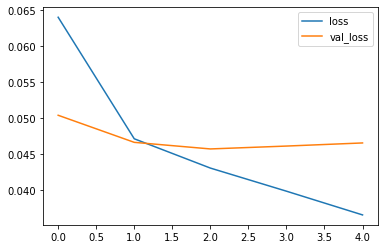

In [13]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

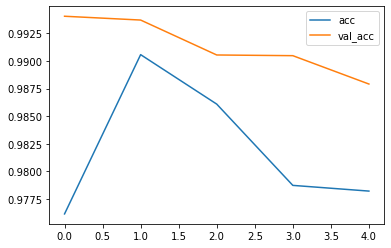

In [14]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [15]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9916872229605471
